In [1]:
#### IMPORTANT NOTE ########
#
#
# THIS CODE WAS MADE WITH TENSORFLOW 2.3.0
# IT WILL NOT RUN WITH 2.5.0 version or newer 
#
#
#### END OF NOTE #####

In [1]:
#GENERAL
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#PATH PROCESS
import os
import os.path
from pathlib import Path
import glob
#IMAGE PROCESS
from PIL import Image
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from keras.applications.vgg16 import preprocess_input, decode_predictions
#SCALER & TRANSFORMATION
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from keras import regularizers
from sklearn.preprocessing import LabelEncoder
#ACCURACY CONTROL
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
#OPTIMIZER
from keras.optimizers import RMSprop,Adam,Optimizer,Optimizer
#MODEL LAYERS
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization,MaxPooling2D,BatchNormalization,\
                        Permute, TimeDistributed, Bidirectional,GRU, SimpleRNN, LSTM, GlobalAveragePooling2D, SeparableConv2D
from keras import models
from keras import layers
import tensorflow as tf
from keras.applications import VGG16,VGG19,inception_v3
from keras import backend as K
from keras.utils import plot_model
#SKLEARN CLASSIFIER
from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import ElasticNetCV
#IGNORING WARNINGS
from warnings import filterwarnings
filterwarnings("ignore",category=DeprecationWarning)
filterwarnings("ignore", category=FutureWarning) 
filterwarnings("ignore", category=UserWarning)

In [2]:
#setting up path to images
database_path = Path("fire_dataset")
image_path = list(database_path.glob(r"*/*.png"))

In [3]:
#creating labels for images
image_labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1],image_path))

In [4]:
print("FIRE: ", image_labels.count("fire_images"))
print("NO_FIRE: ", image_labels.count("non_fire_images"))

FIRE:  755
NO_FIRE:  244


In [5]:
#transform to dataframe and shuffle
image_path_series = pd.Series(image_path,name="PNG").astype(str)
image_labels_series = pd.Series(image_labels,name="CATEGORY")
image_labels_series.replace({"non_fire_images":"NO_FIRE","fire_images":"FIRE"},inplace=True)
image_train_df = pd.concat([image_path_series,image_labels_series],axis=1)
image_train_df = image_train_df.sample(frac=1).reset_index(drop=True)
image_train_df.head()

PNG CATEGORY
0  fire_dataset\non_fire_images\non_fire.102.png  NO_FIRE
1  fire_dataset\non_fire_images\non_fire.117.png  NO_FIRE
2          fire_dataset\fire_images\fire.371.png     FIRE
3          fire_dataset\fire_images\fire.180.png     FIRE
4          fire_dataset\fire_images\fire.501.png     FIRE

In [6]:
#remove broken image
remove_PNG = 'fire_dataset/non_fire_images/non_fire.189.png'
image_train_df = image_train_df.loc[~(image_train_df.loc[:,'PNG'] == remove_PNG),:]
print(image_train_df.loc[image_train_df.loc[:,'PNG'] == remove_PNG,:])

Empty DataFrame
Columns: [PNG, CATEGORY]
Index: []


In [7]:
image_train_df.head()

PNG CATEGORY
0  fire_dataset\non_fire_images\non_fire.102.png  NO_FIRE
1  fire_dataset\non_fire_images\non_fire.117.png  NO_FIRE
2          fire_dataset\fire_images\fire.371.png     FIRE
3          fire_dataset\fire_images\fire.180.png     FIRE
4          fire_dataset\fire_images\fire.501.png     FIRE

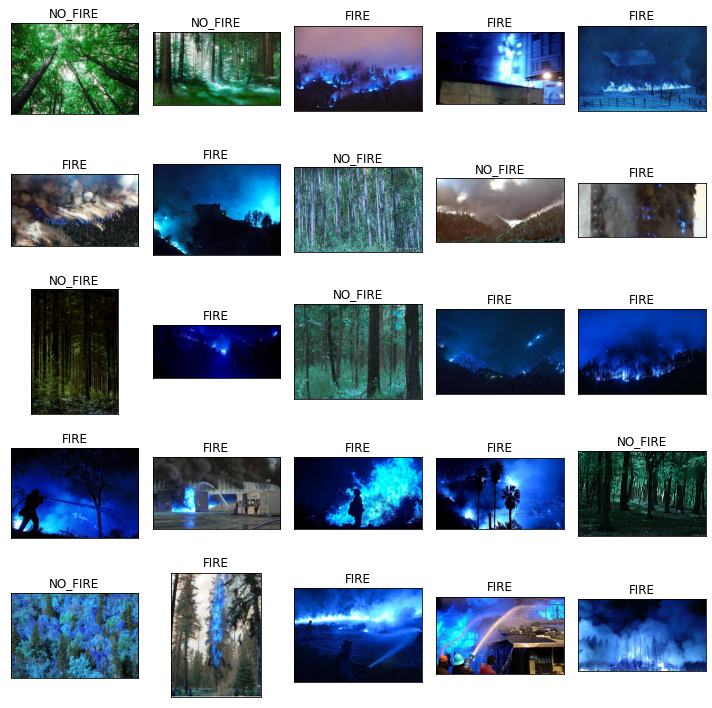

In [8]:
#sample images
fig, axes = plt.subplots(nrows=5,
                        ncols=5,
                        figsize=(10,10),
                        subplot_kw={"xticks":[],"yticks":[]})

for i,ax in enumerate(axes.flat):
    ax.imshow(cv2.imread(image_train_df["PNG"][i]))
    ax.set_title(image_train_df["CATEGORY"][i])
plt.tight_layout()
plt.show()

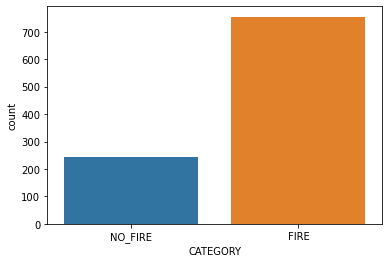

In [9]:
#bar graph of dataset
sns.countplot(image_train_df["CATEGORY"])
plt.show()

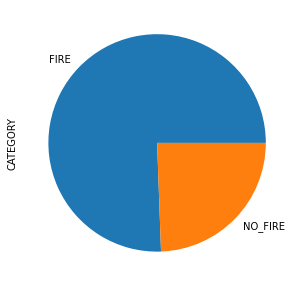

In [10]:
#pie graph of dataset
image_train_df['CATEGORY'].value_counts().plot.pie(figsize=(5,5))
plt.show()

In [11]:
#preprocessing and splitting of train and test data
Train_Generator = ImageDataGenerator(rescale=1./255,
                                    shear_range=0.3,
                                    zoom_range=0.2,
                                    brightness_range=[0.2,0.9],
                                    rotation_range=30,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    fill_mode="nearest",
                                    validation_split=0.1)

In [12]:
#rescaling images 
Test_Generator = ImageDataGenerator(rescale=1./255)

In [13]:
#train/test split
Train_Data,Test_Data = train_test_split(image_train_df,train_size=0.8,random_state=42,shuffle=True)

In [14]:
#shape of training and test
print("TRAIN SHAPE: ",Train_Data.shape)
print("TEST SHAPE: ",Test_Data.shape)

TRAIN SHAPE:  (799, 2)
TEST SHAPE:  (200, 2)


In [15]:
#number of images belonging to fire and no fire
print(Test_Data["CATEGORY"].value_counts())

FIRE       152
NO_FIRE     48
Name: CATEGORY, dtype: int64


In [16]:
#setting up encoder function
encode = LabelEncoder()

In [17]:
#encoding category class for fire/nofire
For_Prediction_Class = encode.fit_transform(Test_Data["CATEGORY"])

In [18]:
#preprocessing of training images
Train_IMG_Set = Train_Generator.flow_from_dataframe(dataframe=Train_Data,
                                                   x_col="PNG",
                                                   y_col="CATEGORY",
                                                   color_mode="rgb",
                                                   class_mode="categorical",
                                                   batch_size=32,
                                                   subset="training")

Found 720 validated image filenames belonging to 2 classes.


In [19]:
#preprocessing of validation images
Validation_IMG_Set = Train_Generator.flow_from_dataframe(dataframe=Train_Data,
                                                   x_col="PNG",
                                                   y_col="CATEGORY",
                                                   color_mode="rgb",
                                                   class_mode="categorical",
                                                   batch_size=32,
                                                   subset="validation")

Found 79 validated image filenames belonging to 2 classes.


In [20]:
#preprocessing of testing images
Test_IMG_Set = Test_Generator.flow_from_dataframe(dataframe=Test_Data,
                                                 x_col="PNG",
                                                 y_col="CATEGORY",
                                                 color_mode="rgb",
                                                 class_mode="categorical",
                                                 batch_size=32)

Found 200 validated image filenames belonging to 2 classes.


In [21]:
#shape of images and labels
for data_batch,label_batch in Train_IMG_Set:
    print("DATA SHAPE: ",data_batch.shape)
    print("LABEL SHAPE: ",label_batch.shape)
    break

DATA SHAPE:  (32, 256, 256, 3)
LABEL SHAPE:  (32, 2)


In [22]:
#shape of images and labels
for data_batch,label_batch in Validation_IMG_Set:
    print("DATA SHAPE: ",data_batch.shape)
    print("LABEL SHAPE: ",label_batch.shape)
    break

DATA SHAPE:  (32, 256, 256, 3)
LABEL SHAPE:  (32, 2)


In [23]:
#shape of images and labels
for data_batch,label_batch in Test_IMG_Set:
    print("DATA SHAPE: ",data_batch.shape)
    print("LABEL SHAPE: ",label_batch.shape)
    break

DATA SHAPE:  (32, 256, 256, 3)
LABEL SHAPE:  (32, 2)


In [24]:
#validating format of data
print("TRAIN: ")
print(Train_IMG_Set.class_indices)
print(Train_IMG_Set.classes[0:5])
print(Train_IMG_Set.image_shape)
print("---"*20)
print("VALIDATION: ")
print(Validation_IMG_Set.class_indices)
print(Validation_IMG_Set.classes[0:5])
print(Validation_IMG_Set.image_shape)
print("---"*20)
print("TEST: ")
print(Test_IMG_Set.class_indices)
print(Test_IMG_Set.classes[0:5])
print(Test_IMG_Set.image_shape)

TRAIN: 
{'FIRE': 0, 'NO_FIRE': 1}
[1, 0, 0, 0, 0]
(256, 256, 3)
------------------------------------------------------------
VALIDATION: 
{'FIRE': 0, 'NO_FIRE': 1}
[0, 0, 1, 1, 0]
(256, 256, 3)
------------------------------------------------------------
TEST: 
{'FIRE': 0, 'NO_FIRE': 1}
[0, 0, 0, 0, 0]
(256, 256, 3)


In [25]:
#resnet model
from keras.layers import Dense, Dropout, GlobalMaxPooling2D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.applications import ResNet50
model = Sequential()
model.add(ResNet50(input_shape=(256, 256, 3), weights='imagenet', include_top=False))
model.add(GlobalMaxPooling2D())
model.add(Dropout(0.5))
model.add(Dense(2,activation='softmax'))

In [26]:
#compiling model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 8, 8, 2048)        23587712  
_________________________________________________________________
global_max_pooling2d (Global (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 4098      
Total params: 23,591,810
Trainable params: 23,538,690
Non-trainable params: 53,120
_________________________________________________________________


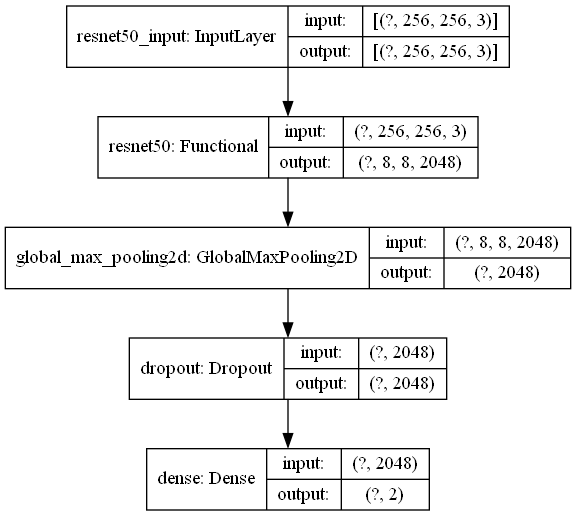

In [27]:
#visualizing the model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [28]:
#training the model
history = model.fit(Train_IMG_Set,
                      validation_data=Validation_IMG_Set,
                      epochs=50)

Epoch 1/50
23/23 [==============================] - 168s 7s/step - loss: 2.1728 - accuracy: 0.7639 - val_loss: 0.6363 - val_accuracy: 0.8228
Epoch 2/50
23/23 [==============================] - 166s 7s/step - loss: 0.6776 - accuracy: 0.9333 - val_loss: 3.7330 - val_accuracy: 0.1772
Epoch 3/50
23/23 [==============================] - 165s 7s/step - loss: 0.5280 - accuracy: 0.9472 - val_loss: 1.7841 - val_accuracy: 0.1772
Epoch 4/50
23/23 [==============================] - 165s 7s/step - loss: 0.3615 - accuracy: 0.9625 - val_loss: 0.4385 - val_accuracy: 0.8354
Epoch 5/50
23/23 [==============================] - 165s 7s/step - loss: 0.3013 - accuracy: 0.9667 - val_loss: 1.6476 - val_accuracy: 0.8228
Epoch 6/50
23/23 [==============================] - 165s 7s/step - loss: 0.1843 - accuracy: 0.9778 - val_loss: 2.6633 - val_accuracy: 0.8228
Epoch 7/50
23/23 [==============================] - 165s 7s/step - loss: 0.3112 - accuracy: 0.9667 - val_loss: 2.7180 - val_accuracy: 0.8228
Epoch 8/50
23

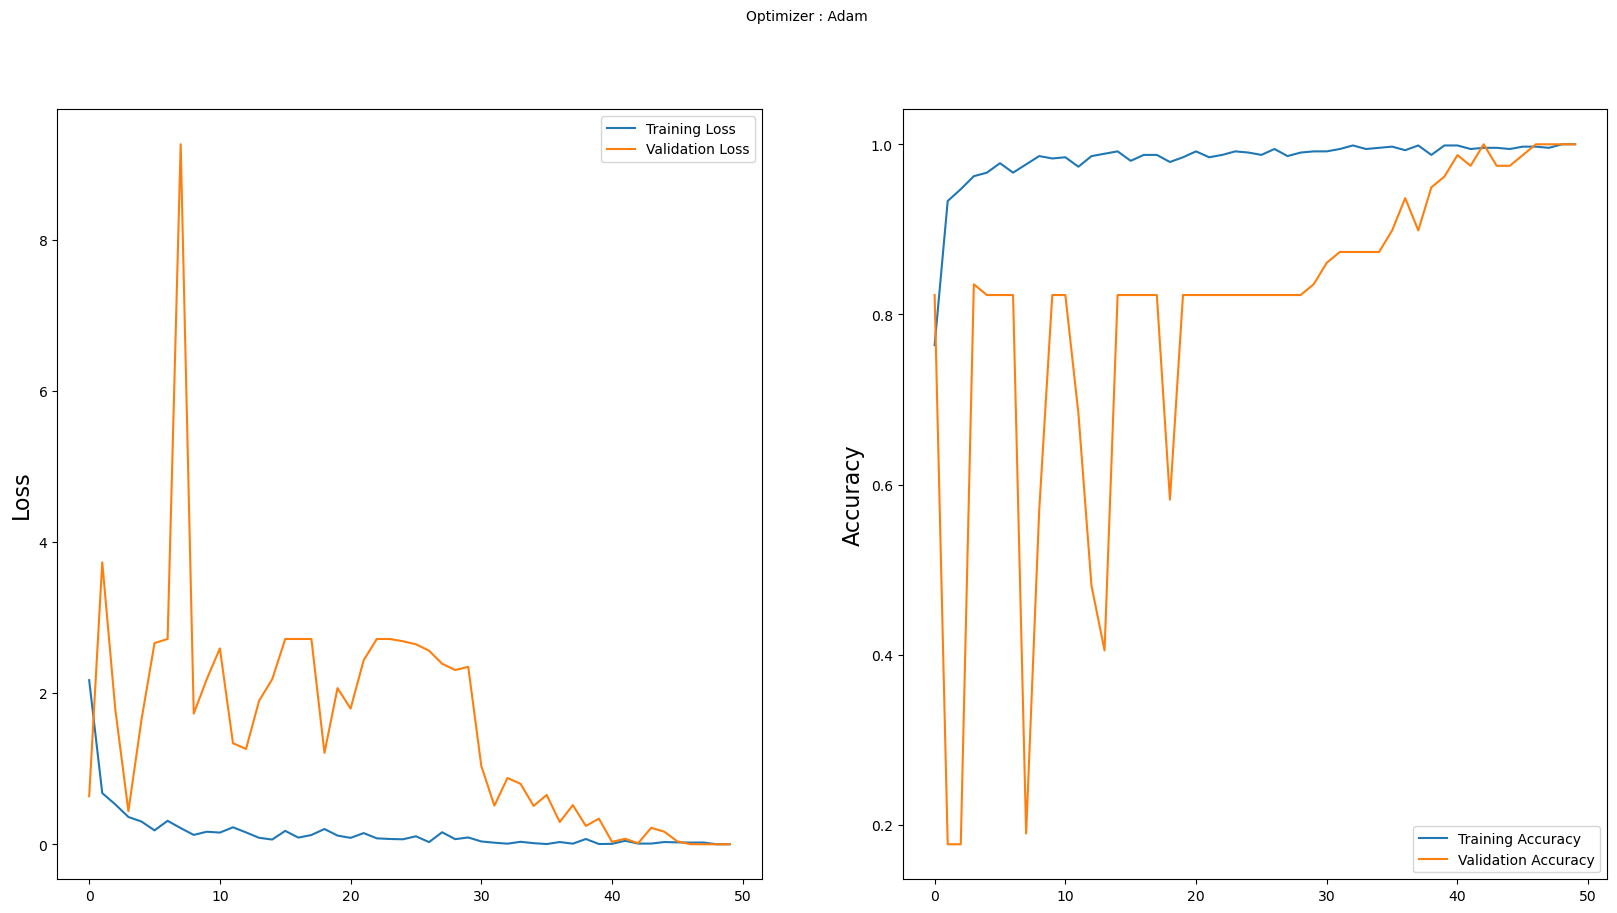

In [29]:
#plotting accuracy and loss
plt.style.use('default')

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [35]:
#testing results
results = model.evaluate(Test_IMG_Set)
preds   = model.predict(Test_IMG_Set)
print('The current model achieved a categorical accuracy of {}%!'.format(round(results[1]*100,2)))

7/7 [==============================] - 8s 1s/step - loss: 0.0964 - accuracy: 0.9900
The current model achieved a categorical accuracy of 99.0%!


In [36]:
#storing test predictions
Prediction_One = model.predict(Test_IMG_Set)
Prediction_One = Prediction_One.argmax(axis=-1)
Predict_Class = model.predict_classes(Test_IMG_Set)

In [37]:
#confusion matrix and other metrics
print(confusion_matrix(For_Prediction_Class,Predict_Class))
print(classification_report(For_Prediction_Class,Predict_Class))

[[115  37]
 [ 37  11]]
              precision    recall  f1-score   support

           0       0.76      0.76      0.76       152
           1       0.23      0.23      0.23        48

    accuracy                           0.63       200
   macro avg       0.49      0.49      0.49       200
weighted avg       0.63      0.63      0.63       200



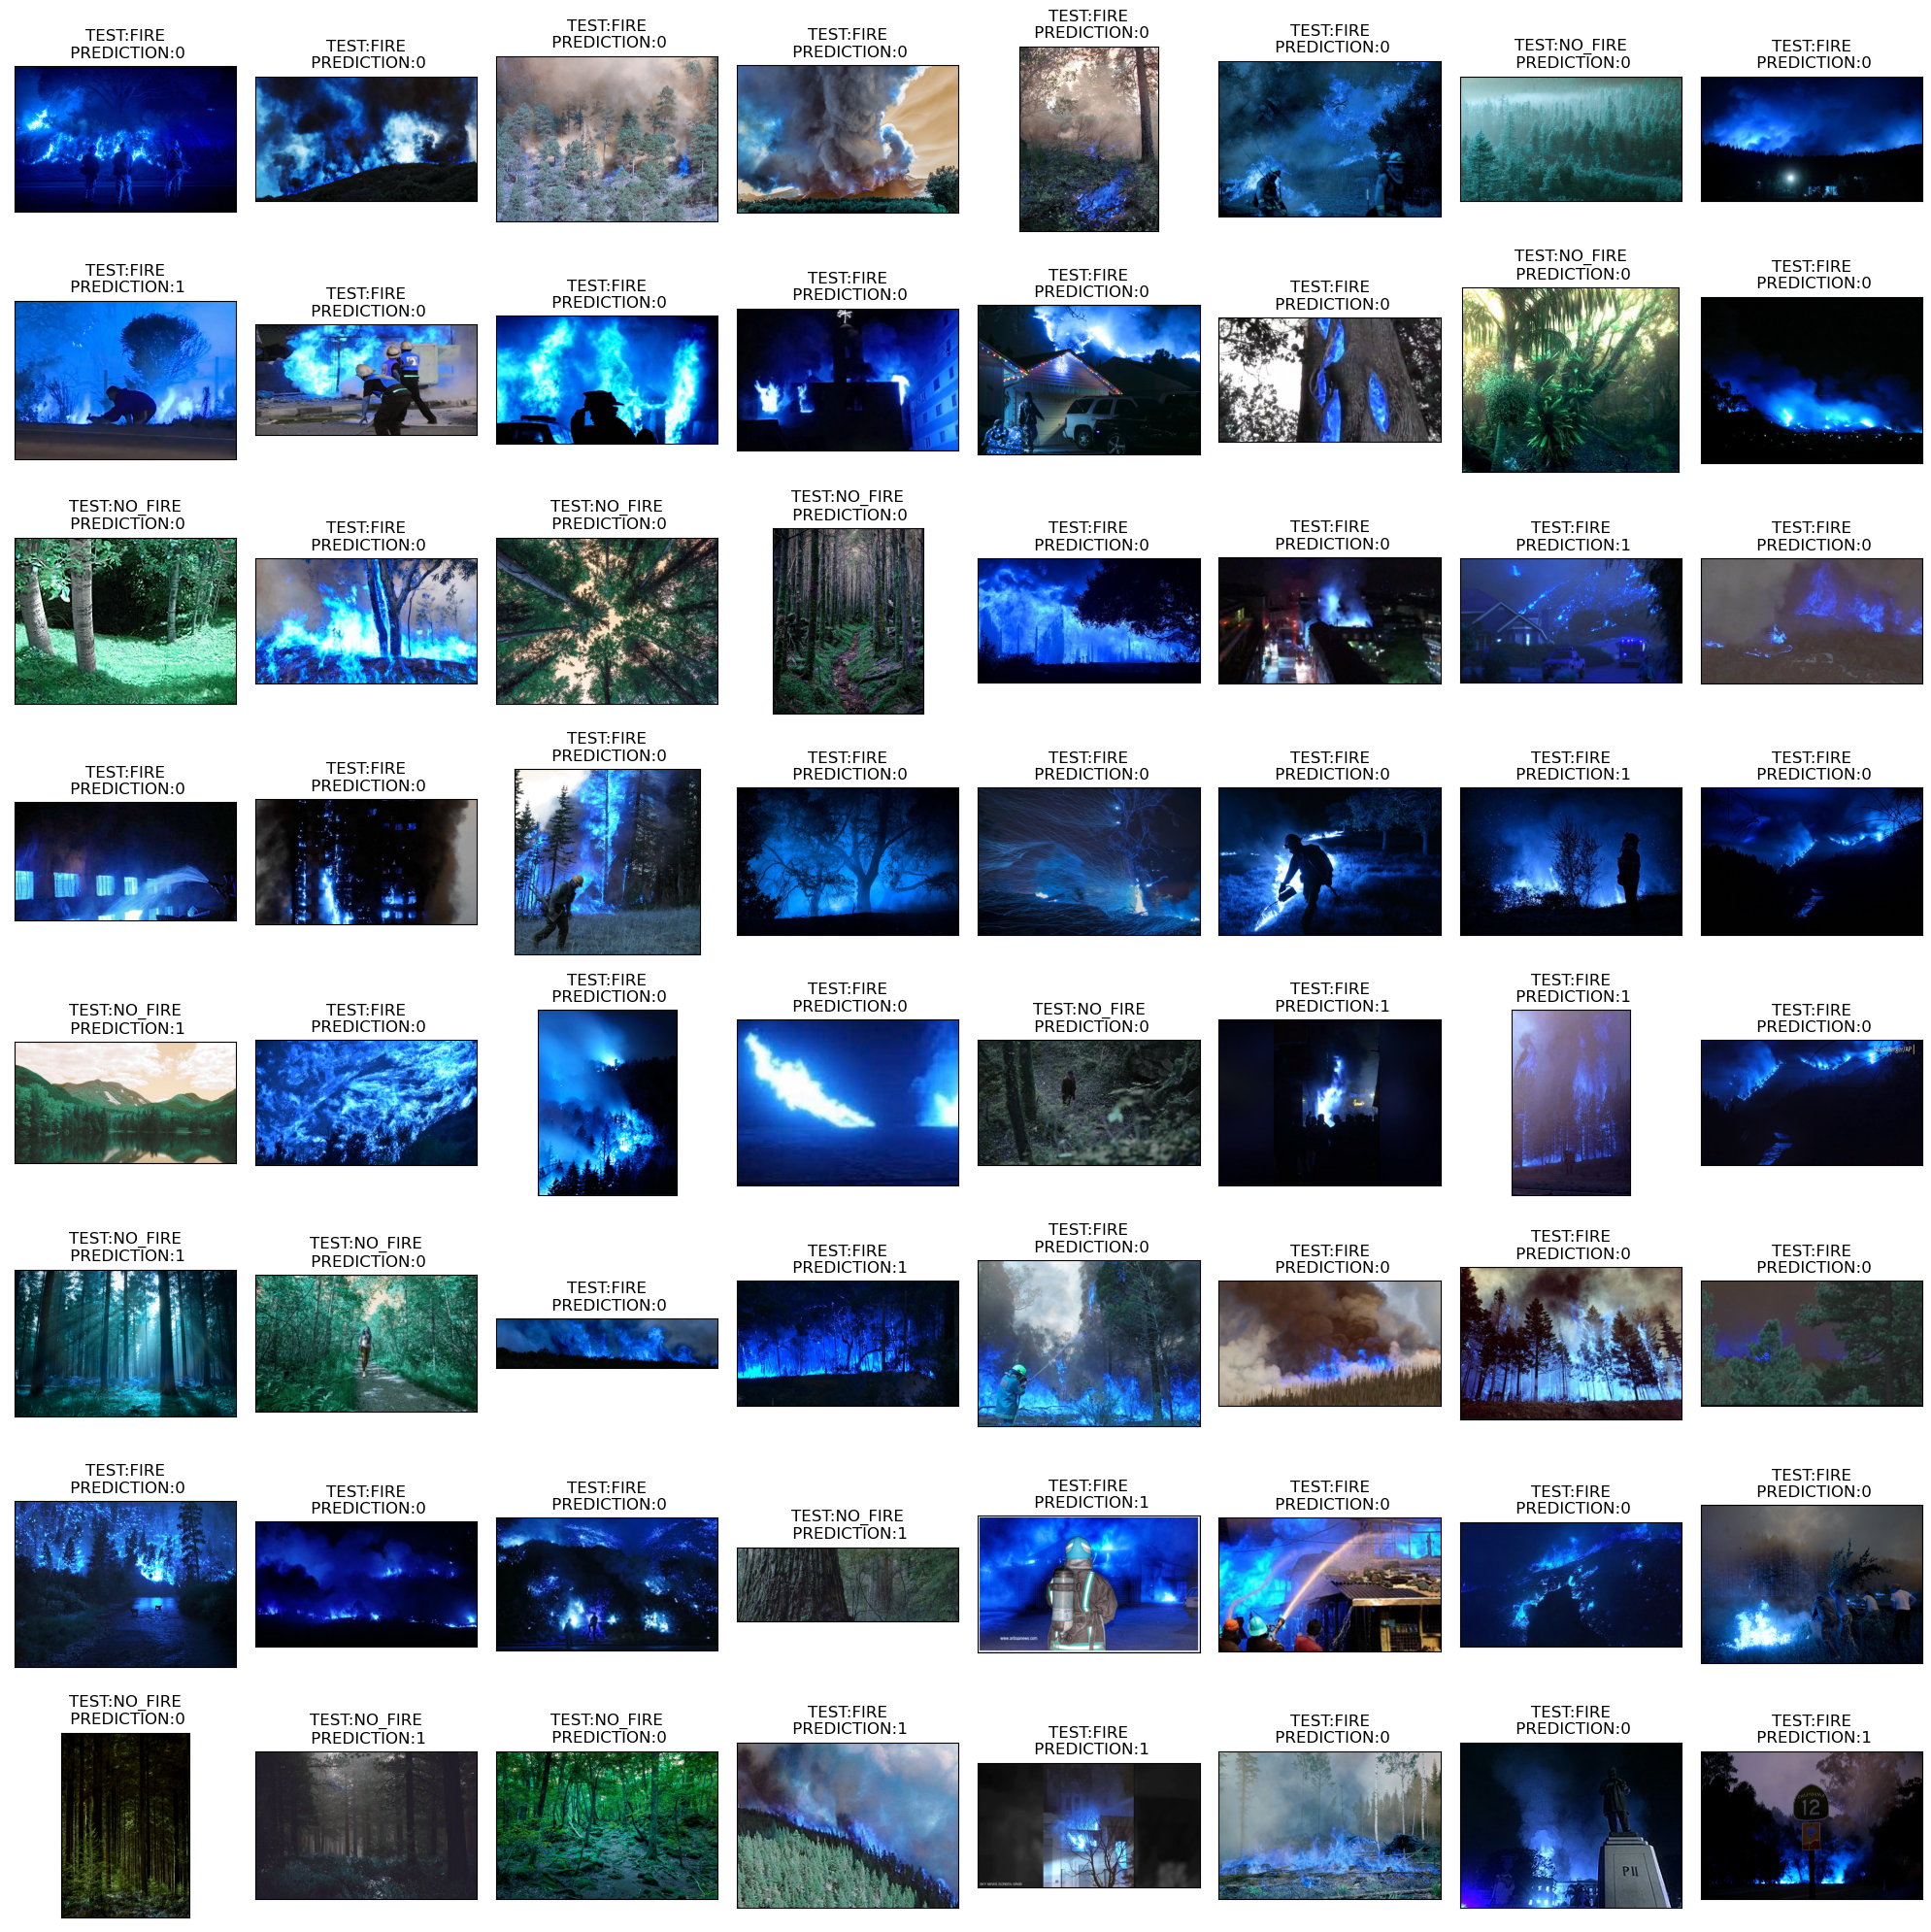

In [38]:
#images with predicted labels
fig, axes = plt.subplots(nrows=8,
                         ncols=8,
                         figsize=(20, 20),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(cv2.imread(Test_Data["PNG"].iloc[i]))
    ax.set_title(f"TEST:{Test_Data.CATEGORY.iloc[i]}\n PREDICTION:{Predict_Class[i]}")
plt.tight_layout()
plt.show()